In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb
from xgboost import plot_importance

import matplotlib.pyplot as plt
import seaborn as sns

We first load the primary training table, drop some columns that are either unimportant or highly correlated with others, and introduce 2 new predictors.

In [2]:
train = pd.read_csv("../input/application_train.csv")
train.drop(train.loc[:,'APARTMENTS_MODE':'NONLIVINGAREA_MEDI'].columns, axis=1, inplace=True)
train.drop(['WEEKDAY_APPR_PROCESS_START','HOUR_APPR_PROCESS_START'], axis=1, inplace=True)

In [3]:
#loan amount divided by client's total income
train['CREDIT_DIV_INCOME'] = train['AMT_CREDIT']/train['AMT_INCOME_TOTAL']

#annuity amount divided by client's total income
train['ANNUITY_DIV_INCOME'] = train['AMT_ANNUITY']/train['AMT_INCOME_TOTAL']

In [4]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,...,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_DIV_INCOME,ANNUITY_DIV_INCOME
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,0,0,0,0,0,0,Business Entity Type 3,0.083037,...,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,2.007889,0.121978
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,0,0,0,0,0,0,School,0.311267,...,0.0039,0.0098,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.790750,0.132217
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,0,0,0,0,0,0,Government,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,0.100000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,0,0,0,0,0,0,Business Entity Type 3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2.316167,0.219900
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,0,0,0,0,1,1,Religion,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.222222,0.179963


Next, we load in the following four supplementary tables:

In [5]:
bureau = pd.read_csv("../input/bureau.csv")
bureau_balance = pd.read_csv("../input/bureau_balance.csv")
installments_payments = pd.read_csv("../input/installments_payments.csv")
POS_CASH_balance = pd.read_csv("../input/POS_CASH_balance.csv")

We'll use these 4 supplementary tables to create 3 new tables: 

1. POS_CASH_statistics_df
2. bureau_statistics_df
3. installments_statistics_df

which will later be joined to the train dataframe.

**POS_CASH_balance -> POS_CASH_statistics_df**

POS_CASH_balance contains monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit. The table has one row for each month of history.

In [6]:
#Number of *active* point of sales and cash loans each applicant had with Home Credit
numPOS_Active = POS_CASH_balance.groupby('SK_ID_CURR').apply(
    lambda df: df['SK_ID_PREV'].nunique() - len(df.loc[df['NAME_CONTRACT_STATUS'] == 'Completed'])
)

numPOS_Active.head(n=10)

SK_ID_CURR
100001    0
100002    1
100003    1
100004    0
100005    0
100006    1
100007    2
100008    0
100009    1
100010    0
dtype: int64

In [7]:
#Avg DPD for previous months POS and cash loans
SK_DPD_means = POS_CASH_balance.groupby('SK_ID_CURR')['SK_DPD','SK_DPD_DEF'].mean()

In [8]:
#Joining the previous two tables 
POS_CASH_statistics_df = SK_DPD_means.merge(
    numPOS_Active.to_frame(), left_index=True, right_index=True
)

#Rename columns
POS_CASH_statistics_df.columns = ['POS_DPD_avg', 'POS_DPD_DEF_avg', 'numPOS_Active']
POS_CASH_statistics_df.head(n=5)

,POS_DPD_avg,POS_DPD_DEF_avg,numPOS_Active
SK_ID_CURR,,,
100001,0.777778,0.777778,0
100002,0.000000,0.000000,1
100003,0.000000,0.000000,1
100004,0.000000,0.000000,0
100005,0.000000,0.000000,0


**bureau and bureau_balance --> bureau_statistics_df**

The bureau dataframe contains clients' previous credits provided by other financial institutions that were reported to Credit Bureau. The bureau_balance dataframe contains monthly statuses of these previous credits.

Below is an example of the records contained in bureau_balance for a particular Credit Bureau loan.

In [9]:
bureau_balance.loc[bureau_balance['SK_ID_BUREAU'] == 5001799]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
703753,5001799,0,C
703754,5001799,-1,C
703755,5001799,-2,C
703756,5001799,-3,C
703757,5001799,-4,C
703758,5001799,-5,C
703759,5001799,-6,C
703760,5001799,-7,C
703761,5001799,-8,C
703762,5001799,-9,C


In [10]:
#Counts of each Credit Bureau loan's statuses over the months. There is one status for each month of each loan.
# C = closed
# X = status unknown
# 0 = no DPD (days past due)
# 1 = DPD 0-30
# 2 = DPD 31-60
# 3 = DPD 61-90
# 4 = DPD 91-120
# 5 = DPD 120+ or sold or written off

bb_status_counts = bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].value_counts().unstack()
bb_status_counts.head(n=10)

STATUS,0,1,2,3,4,5,C,X
SK_ID_BUREAU,,,,,,,,
5001709,NaN,NaN,NaN,NaN,NaN,NaN,86.0,11.0
5001710,5.0,NaN,NaN,NaN,NaN,NaN,48.0,30.0
5001711,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5001712,10.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN
5001713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0
5001714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0
5001715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0
5001716,27.0,NaN,NaN,NaN,NaN,NaN,39.0,20.0
5001717,17.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN


In [11]:
cols_to_sum = ['1','2','3','4','5'] 

#Number of months where Credit Bureau loan had any DPD
bb_status_counts['1to5'] = bb_status_counts[cols_to_sum].sum(axis=1)

#Proportion of months loan had no DPD
bb_status_counts['dpd_ratio_0'] = bb_status_counts['0']/(bb_status_counts['0']+bb_status_counts['1to5'])

#Proportion of months loan had various DPD totals
bb_status_counts['dpd_ratio_1'] = bb_status_counts['1']/(bb_status_counts['0']+bb_status_counts['1to5'])
bb_status_counts['dpd_ratio_234'] = (bb_status_counts['2']+bb_status_counts['3']+bb_status_counts['4'])/(bb_status_counts['0']+bb_status_counts['1to5'])
bb_status_counts['dpd_ratio_5'] = bb_status_counts['5']/(bb_status_counts['0']+bb_status_counts['1to5'])

bb_status_counts.drop(cols_to_sum, axis=1, inplace=True)
bb_status_counts.head(n=10)

STATUS,0,C,X,1to5,dpd_ratio_0,dpd_ratio_1,dpd_ratio_234,dpd_ratio_5
SK_ID_BUREAU,,,,,,,,
5001709,NaN,86.0,11.0,0.0,NaN,NaN,NaN,NaN
5001710,5.0,48.0,30.0,0.0,1.000000,NaN,NaN,NaN
5001711,3.0,NaN,1.0,0.0,1.000000,NaN,NaN,NaN
5001712,10.0,9.0,NaN,0.0,1.000000,NaN,NaN,NaN
5001713,NaN,NaN,22.0,0.0,NaN,NaN,NaN,NaN
5001714,NaN,NaN,15.0,0.0,NaN,NaN,NaN,NaN
5001715,NaN,NaN,60.0,0.0,NaN,NaN,NaN,NaN
5001716,27.0,39.0,20.0,0.0,1.000000,NaN,NaN,NaN
5001717,17.0,5.0,NaN,0.0,1.000000,NaN,NaN,NaN


In [12]:
#Records for months when the relevant loan was still active
temp = bureau_balance.loc[bureau_balance['STATUS'] != 'C']

#For each loan, record_before_closed contains the record in the bureau_balance table from the month before said loan was 
#(known to be) closed. For active loans, will contain the most recent record.
record_before_closed = temp.loc[temp.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].idxmax()].rename(
    index=str, columns = {"MONTHS_BALANCE":"MONTHS_SINCE_CLOSED"}
)

record_before_closed.head()

,SK_ID_BUREAU,MONTHS_SINCE_CLOSED,STATUS
26079839,5001709,-86,X
2846364,5001710,-48,0
2846399,5001711,0,X
2846412,5001712,-9,0
1415228,5001713,0,X


In [14]:
#Join previous two tables
bureau_balance_summary = record_before_closed.merge(
    bb_status_counts, how='left', left_on='SK_ID_BUREAU', right_index=True
)

bureau_balance_summary.head(n=10)

,SK_ID_BUREAU,MONTHS_SINCE_CLOSED,STATUS,0,C,X,1to5,dpd_ratio_0,dpd_ratio_1,dpd_ratio_234,dpd_ratio_5
26079839,5001709,-86,X,NaN,86.0,11.0,0.0,NaN,NaN,NaN,NaN
2846364,5001710,-48,0,5.0,48.0,30.0,0.0,1.000000,NaN,NaN,NaN
2846399,5001711,0,X,3.0,NaN,1.0,0.0,1.000000,NaN,NaN,NaN
2846412,5001712,-9,0,10.0,9.0,NaN,0.0,1.000000,NaN,NaN,NaN
1415228,5001713,0,X,NaN,NaN,22.0,0.0,NaN,NaN,NaN,NaN
1415250,5001714,0,X,NaN,NaN,15.0,0.0,NaN,NaN,NaN,NaN
2108919,5001715,0,X,NaN,NaN,60.0,0.0,NaN,NaN,NaN,NaN
25508728,5001716,-39,0,27.0,39.0,20.0,0.0,1.000000,NaN,NaN,NaN
2108984,5001717,-5,0,17.0,5.0,NaN,0.0,1.000000,NaN,NaN,NaN
2109004,5001718,-3,0,24.0,3.0,10.0,2.0,0.923077,0.076923,NaN,NaN


Now that we've finished working with the bureau_balance table, lets go back and prep the bureau table.

In [15]:
#maximum amount loan was overdue divided by annuity amount
bureau['MAX_OVERDUE_DIV_ANNUITY'] = bureau['AMT_CREDIT_MAX_OVERDUE']/bureau['AMT_ANNUITY']

#current amount loan is overdue divided by annuity amount
bureau['CUR_OVERDUE_DIV_ANNUITY'] = bureau['AMT_CREDIT_SUM_OVERDUE']/bureau['AMT_ANNUITY']

#loan is active and was once overdue
bureau['ACTIVE_AND_WAS_OVERDUE'] = 1*((bureau['CREDIT_ACTIVE'] == 'Active') & (bureau['AMT_CREDIT_MAX_OVERDUE'] > 0))

#loan is active and is currently overdue
bureau['ACTIVE_AND_OVERDUE'] = 1*((bureau['CREDIT_ACTIVE'] == 'Active') & (bureau['AMT_CREDIT_SUM_OVERDUE'] > 0))

#the proportion of the loan that has been repayed
bureau['REPAYMENT_RATIO'] = (bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT'])/bureau['AMT_CREDIT_SUM']

In [16]:
#Join the bureau table with our summary of the bureau_balance table
bureau = bureau.merge(bureau_balance_summary, how='left', on='SK_ID_BUREAU')

In [17]:
bureau_max = bureau.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 
                                          'REPAYMENT_RATIO', 'MAX_OVERDUE_DIV_ANNUITY', 'CUR_OVERDUE_DIV_ANNUITY', 
                                          'ACTIVE_AND_WAS_OVERDUE', 'ACTIVE_AND_OVERDUE', 'MONTHS_SINCE_CLOSED', 
                                          'dpd_ratio_0','dpd_ratio_1','dpd_ratio_234','dpd_ratio_5'].max()
bureau_max = bureau_max.add_suffix('_max')

bureau_avg = bureau.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE','AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 
                                          'REPAYMENT_RATIO', 'MAX_OVERDUE_DIV_ANNUITY', 'CUR_OVERDUE_DIV_ANNUITY', 
                                          'ACTIVE_AND_WAS_OVERDUE', 'ACTIVE_AND_OVERDUE', 
                                          'dpd_ratio_0','dpd_ratio_1','dpd_ratio_234','dpd_ratio_5'].mean()
bureau_avg = bureau_avg.add_suffix('_avg')

bureau_min = bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE', 'REPAYMENT_RATIO', 'dpd_ratio_0'].min()
bureau_min = bureau_min.add_suffix('_min')

In [18]:
bureau_statistics_df = bureau_max.merge(
    bureau_min, left_index=True, right_index=True
).merge(
    bureau_avg, left_index=True, right_index=True
)

bureau_statistics_df.head()

,CREDIT_DAY_OVERDUE_max,AMT_CREDIT_MAX_OVERDUE_max,CNT_CREDIT_PROLONG_max,REPAYMENT_RATIO_max,MAX_OVERDUE_DIV_ANNUITY_max,CUR_OVERDUE_DIV_ANNUITY_max,ACTIVE_AND_WAS_OVERDUE_max,ACTIVE_AND_OVERDUE_max,MONTHS_SINCE_CLOSED_max,dpd_ratio_0_max,dpd_ratio_1_max,dpd_ratio_234_max,dpd_ratio_5_max,AMT_CREDIT_MAX_OVERDUE_min,REPAYMENT_RATIO_min,dpd_ratio_0_min,CREDIT_DAY_OVERDUE_avg,AMT_CREDIT_MAX_OVERDUE_avg,CNT_CREDIT_PROLONG_avg,REPAYMENT_RATIO_avg,MAX_OVERDUE_DIV_ANNUITY_avg,CUR_OVERDUE_DIV_ANNUITY_avg,ACTIVE_AND_WAS_OVERDUE_avg,ACTIVE_AND_OVERDUE_avg,dpd_ratio_0_avg,dpd_ratio_1_avg,dpd_ratio_234_avg,dpd_ratio_5_avg
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,0,NaN,0,1.0,NaN,0.0,0,0,0.0,1.0,0.076923,NaN,NaN,NaN,0.012595,0.923077,0.0,NaN,0.0,0.717482,NaN,0.0,0.000,0.0,0.989011,0.076923,NaN,NaN
100002,0,5043.645,0,1.0,inf,NaN,1,0,0.0,1.0,0.545455,NaN,NaN,0.0,0.453820,0.454545,0.0,1681.029,0.0,0.863455,inf,NaN,0.125,0.0,0.658194,0.455742,NaN,NaN
100003,0,0.000,0,1.0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0.0,1.000000,NaN,0.0,0.000,0.0,1.000000,NaN,NaN,0.000,0.0,NaN,NaN,NaN,NaN
100004,0,0.000,0,1.0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0.0,1.000000,NaN,0.0,0.000,0.0,1.000000,NaN,NaN,0.000,0.0,NaN,NaN,NaN,NaN
100005,0,0.000,0,1.0,0.000000,0.0,0,0,0.0,1.0,NaN,NaN,NaN,0.0,0.045206,1.000000,0.0,0.000,0.0,0.398744,0.000000,0.0,0.000,0.0,1.000000,NaN,NaN,NaN


**INSTALLMENTS_PAYMENTS --> installments_statistics_df**

installments_payments contains repayment history for previously disbursed Home Credit loans. There is one row for each made and each missed payment.

In [19]:
#Days payment was late
installments_payments['DAYS_LATE'] = installments_payments['DAYS_INSTALMENT'] - installments_payments['DAYS_ENTRY_PAYMENT']

#Amount payment was short
installments_payments['UNDERPAY_AMT'] = installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']

#What proportion of the payment due was paid
installments_payments['PAYMENT_PERC'] = installments_payments['AMT_PAYMENT']/installments_payments['AMT_INSTALMENT']

installments_statistics_df = installments_payments.groupby('SK_ID_CURR')['DAYS_LATE','UNDERPAY_AMT','PAYMENT_PERC'].mean()
installments_statistics_df = installments_statistics_df.add_suffix('_avg')

**Join statistics tables to main table**

In [20]:
train = train.merge(
    POS_CASH_statistics_df, how='left', left_on='SK_ID_CURR', right_index=True
).merge(
    bureau_statistics_df, how='left', left_on='SK_ID_CURR', right_index=True
).merge(
    installments_statistics_df, how='left', left_on='SK_ID_CURR', right_index=True
)

In [21]:
train.head(n=10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_DIV_INCOME,ANNUITY_DIV_INCOME,POS_DPD_avg,POS_DPD_DEF_avg,numPOS_Active,CREDIT_DAY_OVERDUE_max,AMT_CREDIT_MAX_OVERDUE_max,CNT_CREDIT_PROLONG_max,REPAYMENT_RATIO_max,MAX_OVERDUE_DIV_ANNUITY_max,CUR_OVERDUE_DIV_ANNUITY_max,ACTIVE_AND_WAS_OVERDUE_max,ACTIVE_AND_OVERDUE_max,MONTHS_SINCE_CLOSED_max,dpd_ratio_0_max,dpd_ratio_1_max,dpd_ratio_234_max,dpd_ratio_5_max,AMT_CREDIT_MAX_OVERDUE_min,REPAYMENT_RATIO_min,dpd_ratio_0_min,CREDIT_DAY_OVERDUE_avg,AMT_CREDIT_MAX_OVERDUE_avg,CNT_CREDIT_PROLONG_avg,REPAYMENT_RATIO_avg,MAX_OVERDUE_DIV_ANNUITY_avg,CUR_OVERDUE_DIV_ANNUITY_avg,ACTIVE_AND_WAS_OVERDUE_avg,ACTIVE_AND_OVERDUE_avg,dpd_ratio_0_avg,dpd_ratio_1_avg,dpd_ratio_234_avg,dpd_ratio_5_avg,DAYS_LATE_avg,UNDERPAY_AMT_avg,PAYMENT_PERC_avg
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,0,0,0,0,0,0,Business Entity Type 3,0.083037,...,0.0,0.0,0.0,1.0,2.007889,0.121978,0.000000,0.000000,1.0,0.0,5043.645,0.0,1.0,inf,NaN,1.0,0.0,0.0,1.0,0.545455,NaN,NaN,0.0,0.453820,0.454545,0.0,1681.029,0.0,0.863455,inf,NaN,0.125,0.0,0.658194,0.455742,NaN,NaN,20.421053,0.000000,1.000000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,0,0,0,0,0,0,School,0.311267,...,0.0,0.0,0.0,0.0,4.790750,0.132217,0.000000,0.000000,1.0,0.0,0.000,0.0,1.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.000000,NaN,0.0,0.000,0.0,1.000000,NaN,NaN,0.000,0.0,NaN,NaN,NaN,NaN,7.160000,0.000000,1.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,0,0,0,0,0,0,Government,NaN,...,0.0,0.0,0.0,0.0,2.000000,0.100000,0.000000,0.000000,0.0,0.0,0.000,0.0,1.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.000000,NaN,0.0,0.000,0.0,1.000000,NaN,NaN,0.000,0.0,NaN,NaN,NaN,NaN,7.666667,0.000000,1.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,0,0,0,0,0,0,Business Entity Type 3,NaN,...,NaN,NaN,NaN,NaN,2.316167,0.219900,0.000000,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.375000,0.000000,1.000000
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,0,0,0,0,1,1,Religion,NaN,...,0.0,0.0,0.0,0.0,4.222222,0.179963,0.000000,0.000000,2.0,0.0,0.000,0.0,1.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.000000,NaN,0.0,0.000,0.0,1.000000,NaN,NaN,0.000,0.0,NaN,NaN,NaN,NaN,3.636364,452.384318,0.954545
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,"Spouse, partner",State servant,Secondary / seconda

We'll now explore see how much these new tables and new predictors helped our XGBoost model's 5-fold CV AUC score.

In [22]:
y = train['TARGET']
train.drop(['SK_ID_CURR','TARGET','ORGANIZATION_TYPE'], axis=1, inplace=True)
X = pd.get_dummies(train)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)
eval_set = [(X_val, y_val)]

In [25]:
xgb1 = xgb.XGBClassifier(
 learning_rate = 0.1,
 n_estimators=500,
 max_depth=4,
 min_child_weight=2,
 subsample=.8,
 colsample_bytree=.8,
 objective= 'binary:logistic',
 seed=1)

xgb1.fit(X_train, y_train, early_stopping_rounds = 25, eval_metric="auc", eval_set=eval_set, verbose=False)

print("Optimal boosting rounds: {} \nAUC Score: {}".format(xgb1.get_booster().best_ntree_limit, xgb1.get_booster().best_score))

Optimal boosting rounds: 227 
AUC Score: 0.76649


This new information improved our high learning rate XGBoost model's 5-fold CV AUC score from approx .75646 (219 boosting rounds) to .76649 (227 boosting rounds). One should note that the max_depth parameter has changed from 5 to 4, though. 

Note: The AUC score has improved by approx. .01 accross each of the 3 train-test splits I have tried, reaching as high as ~.777 for the random_state=1 split. 

Let's now look at a variable importance plot.

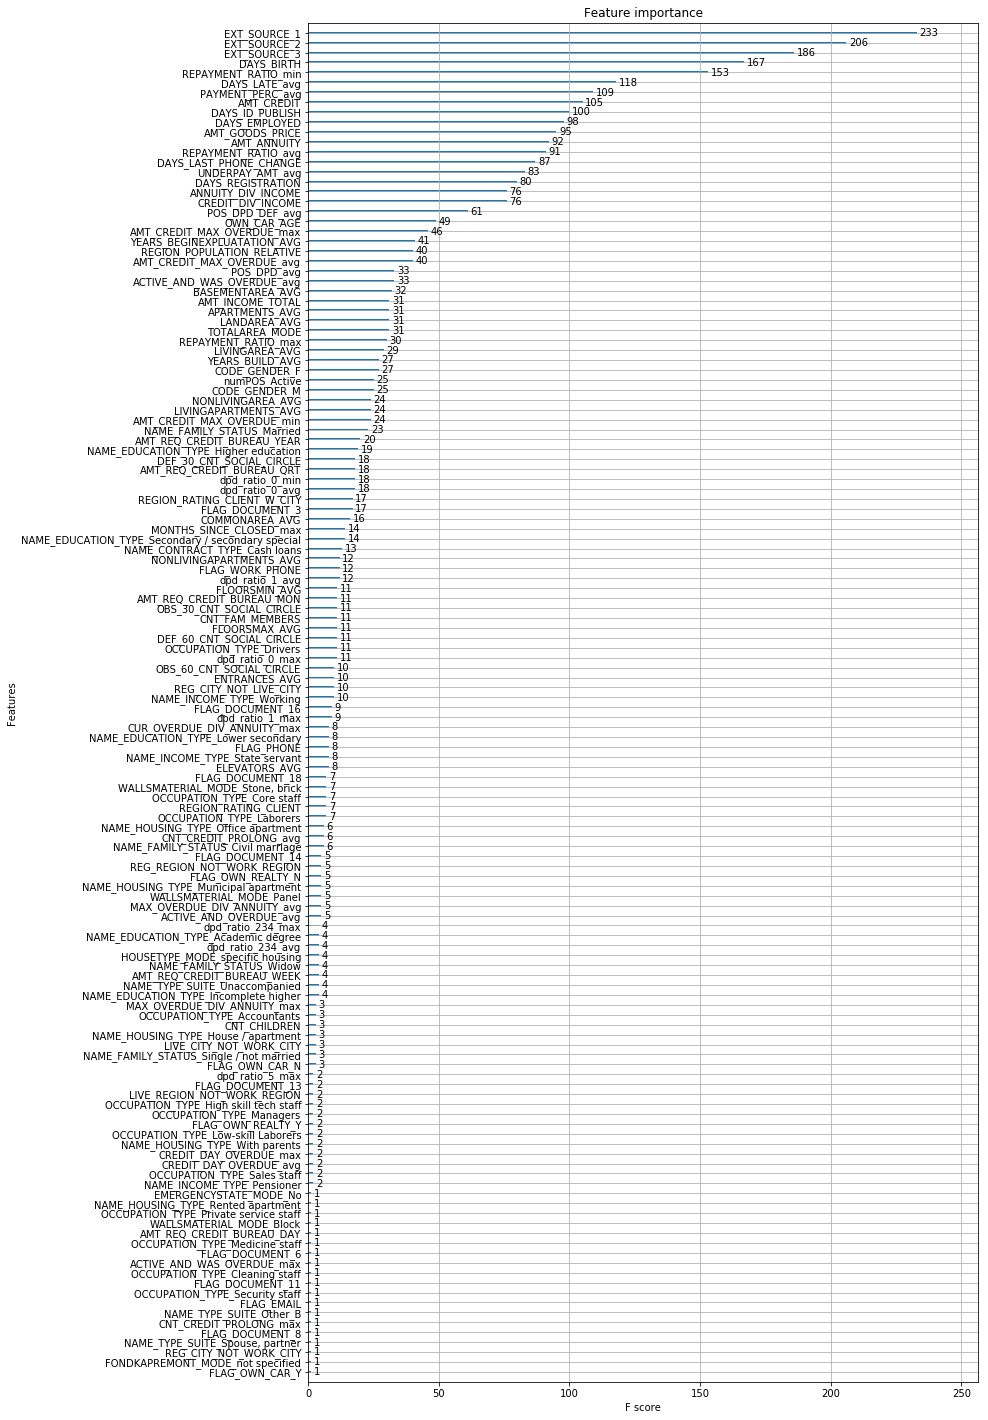

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(12, 25))
myplot = plot_importance(xgb1, ax=ax)
myplot

We'll restrict our model to the 115 most important predictors and retrain.

In [34]:
mycolumns = [t.get_text() for t in myplot.get_yticklabels()]
mycolumns[-115:]

['CREDIT_DAY_OVERDUE_avg',
 'CREDIT_DAY_OVERDUE_max',
 'NAME_HOUSING_TYPE_With parents',
 'OCCUPATION_TYPE_Low-skill Laborers',
 'FLAG_OWN_REALTY_Y',
 'OCCUPATION_TYPE_Managers',
 'OCCUPATION_TYPE_High skill tech staff',
 'LIVE_REGION_NOT_WORK_REGION',
 'FLAG_DOCUMENT_13',
 'dpd_ratio_5_max',
 'FLAG_OWN_CAR_N',
 'NAME_FAMILY_STATUS_Single / not married',
 'LIVE_CITY_NOT_WORK_CITY',
 'NAME_HOUSING_TYPE_House / apartment',
 'CNT_CHILDREN',
 'OCCUPATION_TYPE_Accountants',
 'MAX_OVERDUE_DIV_ANNUITY_max',
 'NAME_EDUCATION_TYPE_Incomplete higher',
 'NAME_TYPE_SUITE_Unaccompanied',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'NAME_FAMILY_STATUS_Widow',
 'HOUSETYPE_MODE_specific housing',
 'dpd_ratio_234_avg',
 'NAME_EDUCATION_TYPE_Academic degree',
 'dpd_ratio_234_max',
 'ACTIVE_AND_OVERDUE_avg',
 'MAX_OVERDUE_DIV_ANNUITY_avg',
 'WALLSMATERIAL_MODE_Panel',
 'NAME_HOUSING_TYPE_Municipal apartment',
 'FLAG_OWN_REALTY_N',
 'REG_REGION_NOT_WORK_REGION',
 'FLAG_DOCUMENT_14',
 'NAME_FAMILY_STATUS_Civil marriag

In [37]:
X = X[mycolumns[-115:]]
X.head()

,CREDIT_DAY_OVERDUE_avg,CREDIT_DAY_OVERDUE_max,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Low-skill Laborers,FLAG_OWN_REALTY_Y,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_High skill tech staff,LIVE_REGION_NOT_WORK_REGION,FLAG_DOCUMENT_13,dpd_ratio_5_max,FLAG_OWN_CAR_N,NAME_FAMILY_STATUS_Single / not married,LIVE_CITY_NOT_WORK_CITY,NAME_HOUSING_TYPE_House / apartment,CNT_CHILDREN,OCCUPATION_TYPE_Accountants,MAX_OVERDUE_DIV_ANNUITY_max,NAME_EDUCATION_TYPE_Incomplete higher,NAME_TYPE_SUITE_Unaccompanied,AMT_REQ_CREDIT_BUREAU_WEEK,NAME_FAMILY_STATUS_Widow,HOUSETYPE_MODE_specific housing,dpd_ratio_234_avg,NAME_EDUCATION_TYPE_Academic degree,dpd_ratio_234_max,ACTIVE_AND_OVERDUE_avg,MAX_OVERDUE_DIV_ANNUITY_avg,WALLSMATERIAL_MODE_Panel,NAME_HOUSING_TYPE_Municipal apartment,FLAG_OWN_REALTY_N,REG_REGION_NOT_WORK_REGION,FLAG_DOCUMENT_14,NAME_FAMILY_STATUS_Civil marriage,CNT_CREDIT_PROLONG_avg,NAME_HOUSING_TYPE_Office apartment,OCCUPATION_TYPE_Laborers,REGION_RATING_CLIENT,OCCUPATION_TYPE_Core staff,"WALLSMATERIAL_MODE_Stone, brick",FLAG_DOCUMENT_18,...,AMT_CREDIT_MAX_OVERDUE_min,LIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,CODE_GENDER_M,numPOS_Active,CODE_GENDER_F,YEARS_BUILD_AVG,LIVINGAREA_AVG,REPAYMENT_RATIO_max,TOTALAREA_MODE,LANDAREA_AVG,APARTMENTS_AVG,AMT_INCOME_TOTAL,BASEMENTAREA_AVG,ACTIVE_AND_WAS_OVERDUE_avg,POS_DPD_avg,AMT_CREDIT_MAX_OVERDUE_avg,REGION_POPULATION_RELATIVE,YEARS_BEGINEXPLUATATION_AVG,AMT_CREDIT_MAX_OVERDUE_max,OWN_CAR_AGE,POS_DPD_DEF_avg,CREDIT_DIV_INCOME,ANNUITY_DIV_INCOME,DAYS_REGISTRATION,UNDERPAY_AMT_avg,DAYS_LAST_PHONE_CHANGE,REPAYMENT_RATIO_avg,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_ID_PUBLISH,AMT_CREDIT,PAYMENT_PERC_avg,DAYS_LATE_avg,REPAYMENT_RATIO_min,DAYS_BIRTH,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1
0,0.0,0.0,0,0,1,0,0,0,0,NaN,1,1,0,1,0,0,inf,0,1,0.0,0,0,NaN,0,NaN,0.0,inf,0,0,0,0,0,0,0.0,0,1,2,0,1,0,...,0.0,0.0202,0.0000,1,1.0,0,0.6192,0.0190,1.0,0.0149,0.0369,0.0247,202500.0,0.0369,0.125,0.0,1681.029,0.018801,0.9722,5043.645,NaN,0.0,2.007889,0.121978,-3648.0,0.000000,-1134.0,0.863455,24700.5,351000.0,-637,-2120,406597.5,1.000000,20.421053,0.45382,-9461,0.139376,0.262949,0.083037
1,0.0,0.0,0,0,0,0,0,0,0,NaN,1,0,0,1,0,0,NaN,0,0,0.0,0,0,NaN,0,NaN,0.0,NaN,0,0,1,0,0,0,0.0,0,0,1,1,0,0,...,0.0,0.0773,0.0098,0,1.0,1,0.7960,0.0549,1.0,0.0714,0.0130,0.0959,270000.0,0.0529,0.000,0.0,0.000,0.003541,0.9851,0.000,NaN,0.0,4.790750,0.132217,-1186.0,0.000000,-828.0,1.000000,35698.5,1129500.0,-1188,-291,1293502.5,1.000000,7.160000,1.00000,-16765,NaN,0.622246,0.311267
2,0.0,0.0,0,0,1,0,0,0,0,NaN,0,1,0,1,0,0,NaN,0,1,0.0,0,0,NaN,0,NaN,0.0,NaN,0,0,0,0,0,0,0.0,0,1,2,0,0,0,...,0.0,NaN,NaN,1,0.0,0,NaN,NaN,1.0,NaN,NaN,NaN,67500.0,NaN,0.000,0.0,0.000,0.010032,NaN,0.000,26.0,0.0,2.000000,0.100000,-4260.0,0.000000,-815.0,1.000000,6750.0,135000.0,-225,-2531,135000.0,1.000000,7.666667,1.00000,-19046,0.729567,0.555912,NaN
3,NaN,NaN,0,0,1,0,0,0,0,NaN,1,0,0,1,0,0,NaN,0,1,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0,0,0,0,1,NaN,0,1,2,0,0,0,...,NaN,NaN,NaN,0,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,135000.0,NaN,NaN,0.0,NaN,0.008019,NaN,NaN,NaN,0.0,2.316167,0.219900,-9833.0,0.000000,-617.0,NaN,29686.5,297000.0,-3039,-2437,312682.5,1.000000,19.375000,NaN,-19005,NaN,0.650442,NaN
4,0.0,0.0,0,0,1,0,0,0,0,NaN,1,1,1,1,0,0,NaN,0,1,0.0,0,0,NaN,0,NaN,0.0,NaN,0,0,0,0,0,0,0.0,0,0,2,1,0,0,...,0.0,NaN,NaN,1,2.0,0,NaN,NaN,1.0,NaN,NaN,NaN,121500.0,NaN,0.000,0.0,0.000,0.028663,NaN,0.000,NaN,0.0,4.222222,0.179963,-4311.0,452.384318,-1106.0,1.000000,21865.5,513000.0,-3038,-3458,513000.0,0.954545,3.636364,1.00000,-19932,NaN,0.322738,NaN


In [39]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

eval_set = [(X_val, y_val)]

In [41]:
xgb2 = xgb.XGBClassifier(
 learning_rate = 0.1,
 n_estimators=500,
 max_depth=4,
 min_child_weight=2,
 subsample=.8,
 colsample_bytree=.8,
 objective= 'binary:logistic',
 seed=1)

xgb2.fit(X_train, y_train, early_stopping_rounds = 25, eval_metric="auc", eval_set=eval_set, verbose=False)

print("Optimal boosting rounds: {} \nAUC Score: {}".format(xgb2.get_booster().best_ntree_limit, xgb2.get_booster().best_score))

Optimal boosting rounds: 237 
AUC Score: 0.767817


Our (high learning rate) XGBoost 5-fold CV AUC score is now up to .767817

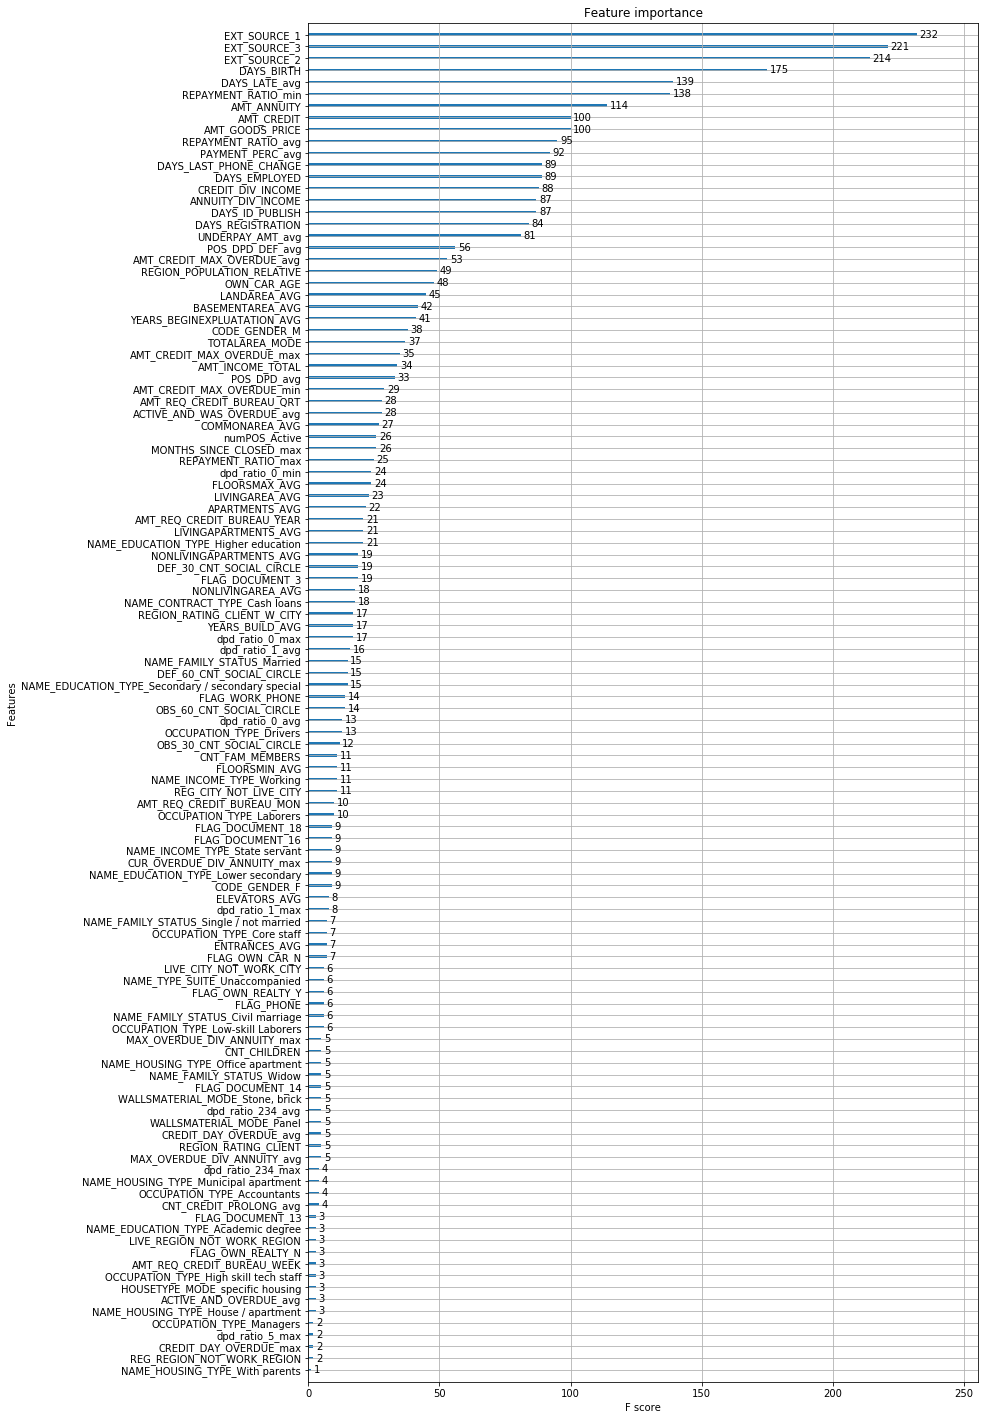

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(12, 25))
plot_importance(xgb2, ax=ax)